In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#pm.help()
#pm.reset()
#pm.init() #debug=True)
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
#df_jo.info()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

#df_jo = df_jo.drop(columns=['Mes_created_at'])
df_jo_cp = df_jo.copy()

df_jo_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         21055 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     32092 non-null  object         
 11  transfer_type               32092 non-nul

# Con user_id

/tmp/ipykernel_143529/43690449.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simpl['transfer_type'] = df_simpl['transfer_type'].map({'regular': 0, 'instant': 1})


transfer_type
1    19488
0    12604
Name: count, dtype: int64


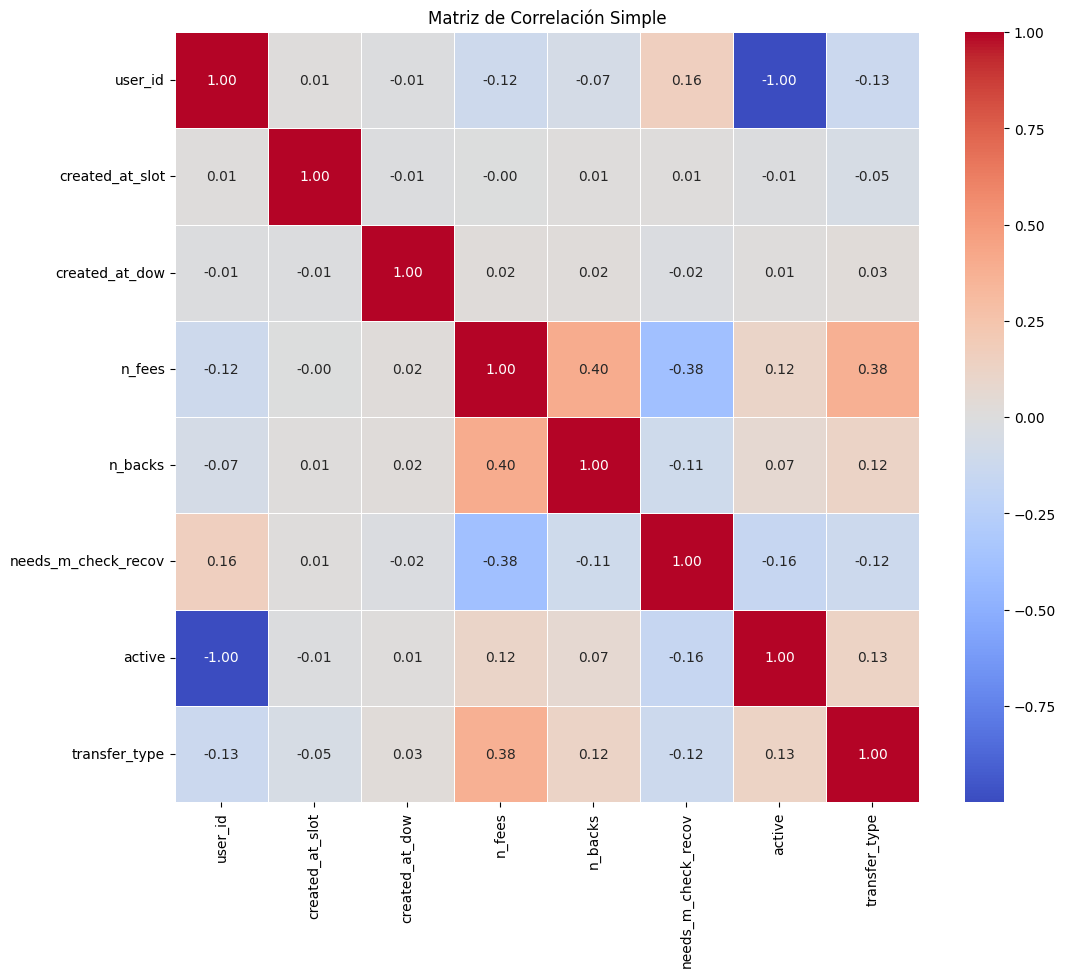

In [21]:
# Lista de columnas que deseas seleccionar
columnas_deseadas = ['user_id', 'created_at_slot', 'created_at_dow' , 'n_fees', 'n_backs', 'needs_m_check_recov', 'active', 'transfer_type']

# Crear un nuevo DataFrame con esas columnas
df_simpl = df_jo_cp[columnas_deseadas]

# Reasignar valores en la columna 'transfer_type'
df_simpl['transfer_type'] = df_simpl['transfer_type'].map({'regular': 0, 'instant': 1})

# Verificar los cambios
print(df_simpl['transfer_type'].value_counts())


# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()

In [ ]:
# Vamos a probar modelo de REGRESIÓN LOGÍSTICA con lo que tenemos para practicar

# Crea la matriz de características y la var objetivo
X = df_simpl.drop(columns=['needs_m_check_recov', 'active','transfer_type'])  # Elimina la columna 'good_user' por nombre
y = df_simpl['needs_m_check_recov']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=None)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]



[[ 1.34410929e-08  1.98429901e-15 -3.99272387e-17 -3.93207636e-15
  -2.28515887e-15 -2.44653043e-17]]


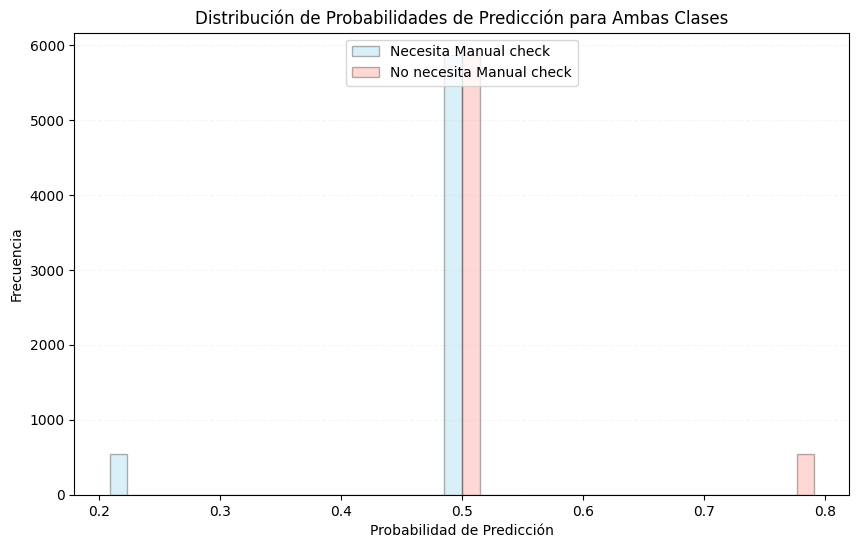

In [4]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [5]:
# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_2 = X_test.reset_index().copy()
X_2["needs_m_check_recov"] = y_test.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_2["prediccion"] = predicciones
X_2 = pd.concat([X_2, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_2[["needs_m_check_recov", "prediccion", 0, 1]].head(20)

,needs_m_check_recov,prediccion,0,1
0,1,1,0.499966,0.500034
1,1,1,0.499898,0.500102
2,0,1,0.499939,0.500061
3,0,1,0.499969,0.500031
4,0,1,0.499956,0.500044
5,0,1,0.499950,0.500050
6,1,1,0.499715,0.500285
7,0,1,0.499952,0.500048
8,1,1,0.499705,0.500295
9,0,1,0.499978,0.500022


Text(70.5815972222222, 0.5, 'Realidad')

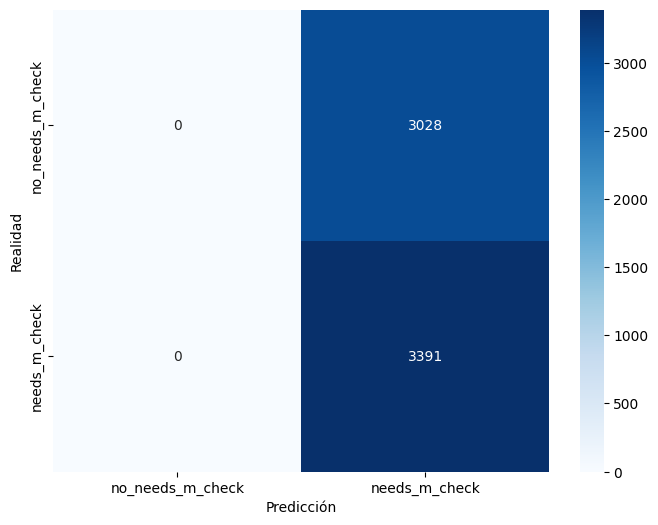

In [6]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

No vamos a usar el user_id porque sino todas necesitan manual check. 


# Ahora solo con los user_id activos pero sin usar columna user_id

In [7]:
df_simpl_1=df_simpl[df_simpl['active']==1]

df_simpl_1

,user_id,created_at_slot,created_at_dow,n_fees,n_backs,needs_m_check_recov,active
0,47,7,1,0,0,1,1
2,804,14,1,0,0,1,1
3,812,14,1,0,0,1,1
4,191,14,1,0,0,1,1
5,430,14,1,0,1,1,1
...,...,...,...,...,...,...,...
32087,55916,21,6,2,2,0,1
32088,39339,21,6,3,3,0,1
32089,24505,21,6,0,0,1,1
32090,100781,21,6,1,1,0,1


In [8]:
# Vamos a probar modelo de REGRESIÓN LOGÍSTICA con lo que tenemos para practicar

# Crea la matriz de características y la var objetivo
X = df_simpl_1.drop(columns=['needs_m_check_recov'])  # Elimina la columna 'good_user' por nombre
y = df_simpl_1['needs_m_check_recov']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=None)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]



[[-6.52392635e-06  1.69415800e-02  5.25209311e-02 -7.13132601e-01
   8.05191340e-02  9.80276695e-02]]


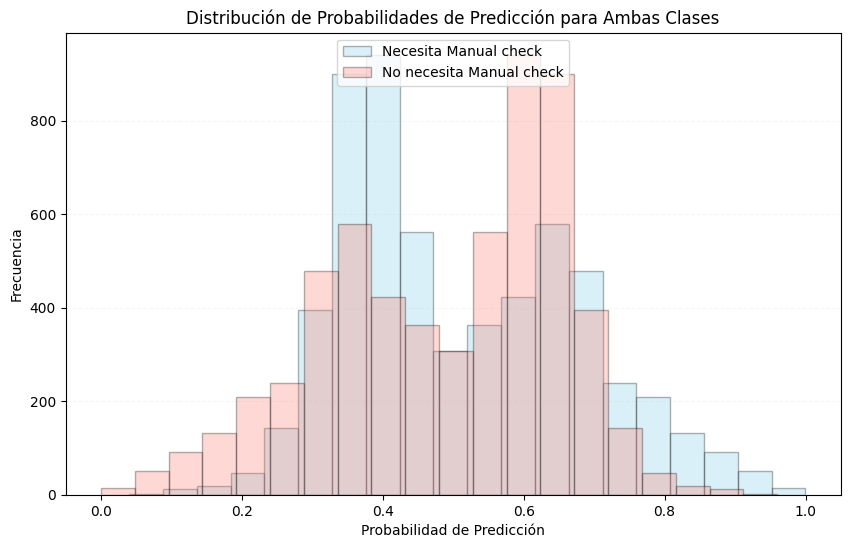

In [9]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [10]:
# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_2 = X_test.reset_index().copy()
X_2["needs_m_check_recov"] = y_test.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_2["prediccion"] = predicciones
X_2 = pd.concat([X_2, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_2[["needs_m_check_recov", "prediccion", 0, 1]].head(20)

,needs_m_check_recov,prediccion,0,1
0,0,1,0.252209,0.747791
1,0,1,0.362222,0.637778
2,1,1,0.119649,0.880351
3,1,1,0.386374,0.613626
4,1,1,0.367323,0.632677
5,0,0,0.616013,0.383987
6,1,1,0.378826,0.621174
7,1,0,0.557772,0.442228
8,0,0,0.687504,0.312496
9,1,0,0.580811,0.419189


Text(70.5815972222222, 0.5, 'Realidad')

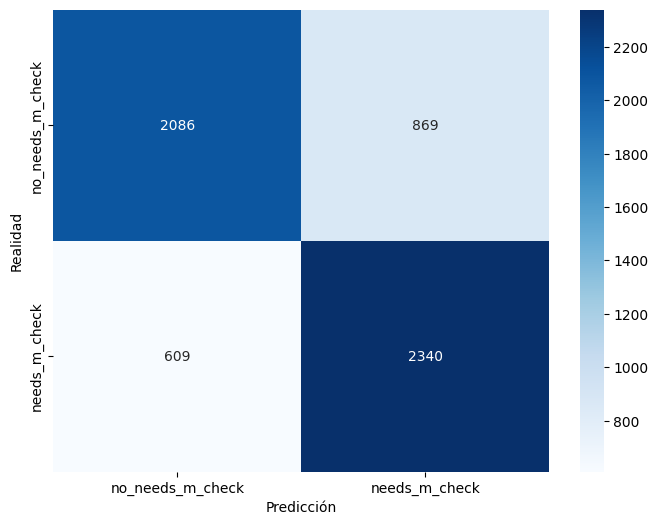

In [11]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

No hay mejora significativa con solo los activos. 

# Ahora solo con los user_id q tienen active=0

In [12]:
df_simpl_0=df_simpl[df_simpl['active']==0]

df_simpl_0

,user_id,created_at_slot,created_at_dow,n_fees,n_backs,needs_m_check_recov,active
1,99001309,14,0,0,1,0,0
19,99004217,21,1,0,1,0,0
24,99000091,7,2,0,0,1,0
31,99000972,7,2,0,0,1,0
32,99003324,14,2,0,0,1,0
...,...,...,...,...,...,...,...
31847,99017691,14,5,0,0,1,0
31881,99025166,14,5,1,1,0,0
31991,99018049,7,6,0,0,1,0
32035,99017998,14,6,0,0,1,0


In [14]:
# Vamos a probar modelo de REGRESIÓN LOGÍSTICA con lo que tenemos para practicar

# Crea la matriz de características y la var objetivo
X = df_simpl_0.drop(columns=['needs_m_check_recov'])  # Elimina la columna 'good_user' por nombre
y = df_simpl_0['needs_m_check_recov']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=None)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]


[[ 1.34751922e-08  1.79418130e-15  3.35529318e-16 -1.16684991e-16
  -3.36307365e-17  0.00000000e+00]]


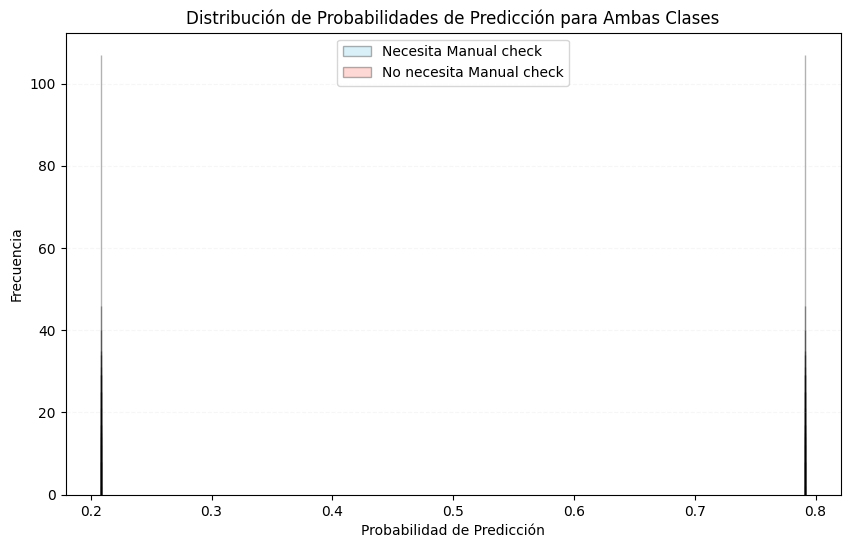

In [15]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [18]:
# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_3 = X_test.reset_index().copy()
X_3["needs_m_check_recov"] = y_test.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_3["prediccion"] = predicciones
X_3 = pd.concat([X_3, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_3[["needs_m_check_recov", "prediccion", 0, 1]].head(20)

,needs_m_check_recov,prediccion,0,1
0,0,1,0.208445,0.791555
1,1,1,0.208487,0.791513
2,1,1,0.208481,0.791519
3,1,1,0.208486,0.791514
4,1,1,0.208462,0.791538
5,1,1,0.208476,0.791524
6,1,1,0.208482,0.791518
7,1,1,0.208471,0.791529
8,1,1,0.208481,0.791519
9,1,1,0.208488,0.791512


Text(70.5815972222222, 0.5, 'Realidad')

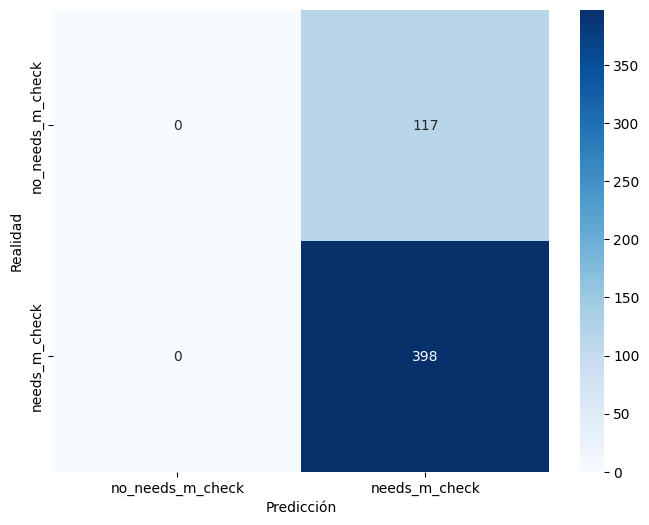

In [19]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

Con solo los deleted no vamos a ningún lugar. Todos necesitarían manual_check.

# Ahora con todos los user_id (active y no active) pero dividimos entre las cr que fueron Instant y las q fueron Regular

In [26]:
df_simpl_I=df_simpl[df_simpl['transfer_type']==1]

df_simpl_I

,user_id,created_at_slot,created_at_dow,n_fees,n_backs,needs_m_check_recov,active,transfer_type
7097,99018281,14,1,0,2,0,0,1
8432,33244,14,2,1,1,0,1,1
8433,33244,14,2,0,2,1,1,1
8772,11588,7,3,0,2,0,1,1
8781,31751,7,3,0,1,0,1,1
...,...,...,...,...,...,...,...,...
32087,55916,21,6,2,2,0,1,1
32088,39339,21,6,3,3,0,1,1
32089,24505,21,6,0,0,1,1,1
32090,100781,21,6,1,1,0,1,1


In [27]:
# Vamos a probar modelo de REGRESIÓN LOGÍSTICA con lo que tenemos para practicar

# Crea la matriz de características y la var objetivo
X = df_simpl_I.drop(columns=['needs_m_check_recov', 'active','user_id'])  # Elimina la columna 'good_user' por nombre
y = df_simpl_I['needs_m_check_recov']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=None)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

[[ 0.00746347 -0.00198005 -1.84929322  0.32526688  0.4829322 ]]


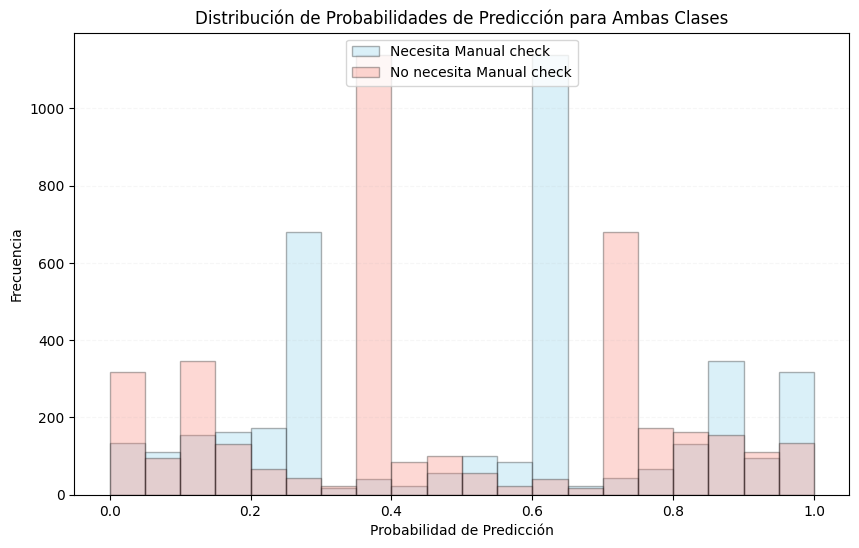

In [28]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [29]:
# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_4 = X_test.reset_index().copy()
X_4["needs_m_check_recov"] = y_test.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_4["prediccion"] = predicciones
X_4 = pd.concat([X_4, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_4[["needs_m_check_recov", "prediccion", 0, 1]].head(20)

,needs_m_check_recov,prediccion,0,1
0,0,0,0.611983,0.388017
1,1,1,0.266556,0.733444
2,1,1,0.246632,0.753368
3,1,1,0.245897,0.754103
4,1,0,0.960015,0.039985
5,0,0,0.611983,0.388017
6,0,0,0.624314,0.375686
7,1,0,0.611983,0.388017
8,1,1,0.158605,0.841395
9,1,1,0.267331,0.732669


Text(70.5815972222222, 0.5, 'Realidad')

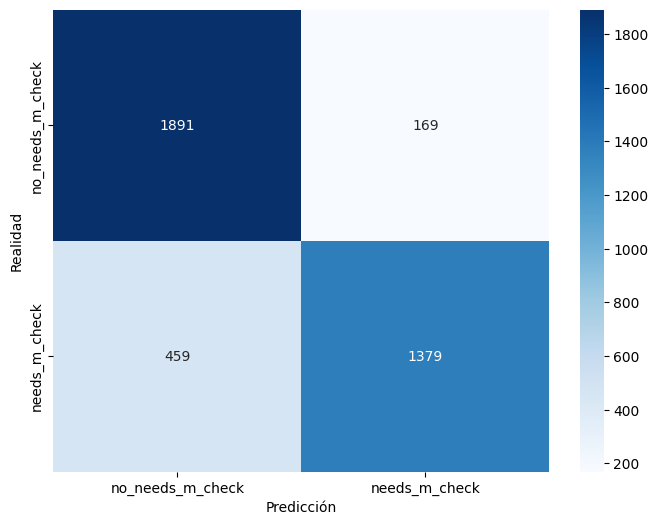

In [30]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

Mejora levemente quizás.

# Ahora solo con Regular

In [31]:
df_simpl_R=df_simpl[df_simpl['transfer_type']==0]

df_simpl_R

,user_id,created_at_slot,created_at_dow,n_fees,n_backs,needs_m_check_recov,active,transfer_type
0,47,7,1,0,0,1,1,0
1,99001309,14,0,0,1,0,0,0
2,804,14,1,0,0,1,1,0
3,812,14,1,0,0,1,1,0
4,191,14,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...
31999,83792,7,6,0,1,0,1,0
32012,102720,7,6,0,0,1,1,0
32060,38250,14,6,0,3,0,1,0
32066,64005,14,6,0,1,0,1,0


In [32]:
# Vamos a probar modelo de REGRESIÓN LOGÍSTICA con lo que tenemos para practicar

# Crea la matriz de características y la var objetivo
X = df_simpl_R.drop(columns=['needs_m_check_recov', 'active','user_id'])  # Elimina la columna 'good_user' por nombre
y = df_simpl_R['needs_m_check_recov']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=None)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

[[ 0.00707211 -0.01672793  0.05088647 -0.16295812  0.        ]]


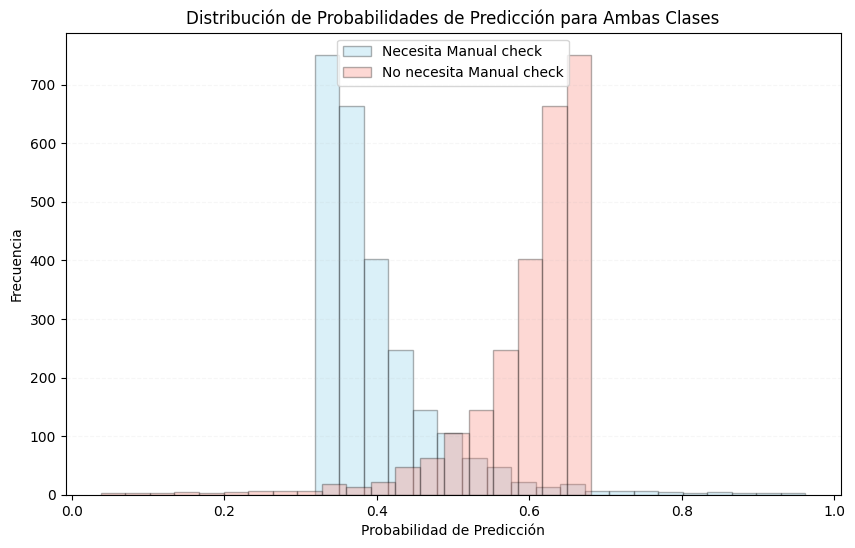

In [33]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [34]:
# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_5 = X_test.reset_index().copy()
X_5["needs_m_check_recov"] = y_test.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_5["prediccion"] = predicciones
X_5 = pd.concat([X_5, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_5[["needs_m_check_recov", "prediccion", 0, 1]].head(20)

,needs_m_check_recov,prediccion,0,1
0,0,1,0.370267,0.629733
1,1,1,0.377941,0.622059
2,1,1,0.461334,0.538666
3,1,1,0.366375,0.633625
4,0,0,0.574552,0.425448
5,0,1,0.408997,0.591003
6,0,1,0.463551,0.536449
7,1,1,0.421015,0.578985
8,1,1,0.497815,0.502185
9,0,1,0.366533,0.633467


Text(70.5815972222222, 0.5, 'Realidad')

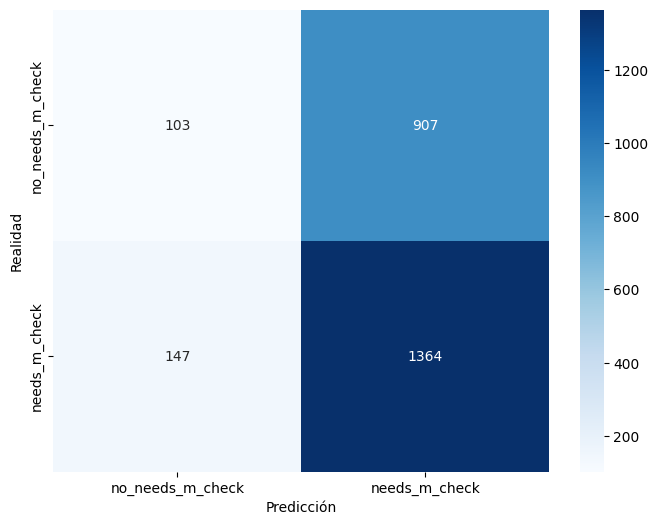

In [35]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

Las reguare solas no funcionan bien. 